### Instalação e Configuração de Bibliotecas

Primeiro, precisamos instalar as bibliotecas necessárias, se ainda não estiverem instaladas, e configurar os hiperparâmetros que usaremos. 
Estamos utilizando o modelo `all-MiniLM-L6-v2` da SBERT para gerar os embeddings iniciais.


In [1]:
# Instale as bibliotecas necessárias se ainda não estiverem instaladas
# !pip install sentence-transformers torch matplotlib scikit-learn pandas

import pandas as pd
import torch
from torch import nn, optim, cosine_similarity
from torch.utils.data import DataLoader, TensorDataset
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Configurações e hiperparâmetros
MODEL_NAME = "all-MiniLM-L6-v2"
EMBEDDING_DIM = 384  # Dimensão dos embeddings do modelo SBERT escolhido
HIDDEN_DIM = 128     # Dimensão da camada intermediária do autoencoder
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.001


c:\Users\guilh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Carregar o Modelo SBERT e Criar o Autoencoder

Nesta etapa, carregamos o modelo SBERT, que será usado para gerar embeddings. Em seguida, definimos o autoencoder que usaremos para ajustar esses embeddings ao nosso dataset. O autoencoder possui uma camada de encoder para reduzir a dimensionalidade e uma camada de decoder para reconstruir o embedding original.


In [2]:
# Carregar modelo SBERT
sbert_model = SentenceTransformer(MODEL_NAME)

# Definir o Autoencoder para ajuste fino dos embeddings
class EmbeddingAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(EmbeddingAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = self.decoder(x)
        return x

# Instanciar o autoencoder
autoencoder = EmbeddingAutoencoder(input_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)


### Gerar Embeddings com SBERT

Aqui, carregamos o dataset e geramos os embeddings para cada documento usando o modelo SBERT. Esses embeddings representam os documentos em um espaço vetorial de alta dimensão.


In [3]:
# Função para gerar embeddings com SBERT
def generate_sbert_embeddings(documents):
    embeddings = sbert_model.encode(documents, convert_to_numpy=True, show_progress_bar=True)
    return torch.tensor(embeddings, dtype=torch.float32)

# Carregar dados e gerar embeddings
def load_data_and_generate_embeddings(csv_path="../data/metadata.csv"):
    df = pd.read_csv(csv_path)
    abstracts = df['abstract'].tolist()
    embeddings = generate_sbert_embeddings(abstracts)
    return embeddings

# Carregar o dataset e gerar os embeddings
embeddings = load_data_and_generate_embeddings()


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

### Preparação e Treinamento do Autoencoder

Usamos o autoencoder para ajustar os embeddings SBERT. Durante o treinamento, o autoencoder aprende a capturar as principais características dos embeddings, ajustando-os ao nosso dataset. O objetivo é refinar a representação vetorial, tornando-a mais relevante para o nosso conjunto de dados específico.


In [4]:
# Preparar dados para o treinamento
train_dataset = TensorDataset(embeddings)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Função de treinamento do autoencoder
def train_autoencoder(model, dataloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            inputs = batch[0]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

# Treinamento do autoencoder
train_autoencoder(autoencoder, train_loader, criterion, optimizer, EPOCHS)


Epoch 1/10, Loss: 0.0011
Epoch 2/10, Loss: 0.0005
Epoch 3/10, Loss: 0.0005
Epoch 4/10, Loss: 0.0004
Epoch 5/10, Loss: 0.0004
Epoch 6/10, Loss: 0.0004
Epoch 7/10, Loss: 0.0004
Epoch 8/10, Loss: 0.0004
Epoch 9/10, Loss: 0.0004
Epoch 10/10, Loss: 0.0004


In [22]:
# Salvar os pesos do modelo no arquivo "autoencoder_model.pth"
torch.save(autoencoder.state_dict(), "autoencoder_model.pth")

### Refinamento dos Embeddings Ajustados e Salvamento (Opcional)

Após o treinamento do autoencoder, usamos a camada `encoder` para obter os embeddings ajustados e, opcionalmente, salvá-los para uso posterior.


In [5]:
# Função para ajustar embeddings com o autoencoder treinado
def refine_embeddings(embeddings, model):
    model.eval()
    with torch.no_grad():
        refined_embeddings = model.encoder(embeddings).numpy()
    return refined_embeddings

# Refinar os embeddings ajustados
refined_embeddings = refine_embeddings(embeddings, autoencoder)

# Salvar embeddings ajustados, se desejar reutilizar depois
torch.save(refined_embeddings, "refined_embeddings.pt")


### Projeção dos Embeddings com t-SNE

Para visualizar os embeddings em 2D, usamos o t-SNE. Ele permite projetar o espaço vetorial de alta dimensão em um espaço bidimensional, facilitando a visualização e a identificação de possíveis agrupamentos.


In [6]:
# Função para projetar embeddings em 2D usando t-SNE
def project_embeddings_tsne(embeddings, perplexity=30, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    projected_embeddings = tsne.fit_transform(embeddings)
    return projected_embeddings

# Projetar os embeddings SBERT pré-treinados e os embeddings ajustados em 2D
sbert_embeddings_2d = project_embeddings_tsne(embeddings)
refined_embeddings_2d = project_embeddings_tsne(refined_embeddings)


c:\Users\guilh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\guilh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


### Visualização dos Embeddings em 2D

Nesta etapa, visualizamos os embeddings em um gráfico de dispersão. Comparamos a organização dos embeddings SBERT pré-treinados e dos embeddings ajustados pelo autoencoder.


In [7]:
# Visualizar embeddings em um gráfico de dispersão e salvar a imagem
def plot_embeddings(embeddings_2d, labels=None, title="Embeddings Visualization", filename="embedding_plot.png"):
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="viridis", s=10, alpha=0.7)
    if labels is not None:
        plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    
    # Salvar a imagem
    plt.savefig(filename)
    plt.close()  # Fechar a plotagem para liberar memória

# Carregar o DataFrame e definir labels (caso existam)
csv_path = "../data/metadata.csv"  # Caminho para o CSV com abstracts
df = pd.read_csv(csv_path)
labels = df['label'] if 'label' in df.columns else None

# Visualizar e salvar os embeddings pré-treinados SBERT
plot_embeddings(sbert_embeddings_2d, labels=labels, title="SBERT Embeddings", filename="../sbert_embeddings.png")

# Visualizar e salvar os embeddings ajustados pelo autoencoder
plot_embeddings(refined_embeddings_2d, labels=labels, title="Refined Embeddings with Autoencoder", filename="../refined_embeddings.png")


C:\Users\guilh\AppData\Local\Temp\ipykernel_81020\2510290998.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="viridis", s=10, alpha=0.7)


### Função de Busca Baseada em Similaridade

Nesta etapa, criamos uma função para buscar documentos semelhantes usando os embeddings refinados. A função recebe uma consulta do usuário, gera seu embedding usando SBERT e calcula a similaridade entre este embedding e os embeddings dos documentos. Em seguida, ordenamos os resultados de acordo com a similaridade para obter os documentos mais relevantes.


In [ ]:
import torch.nn.functional as F

def recommend_papers_with_embeddings(user_interest, document_embeddings, documents, model=sbert_model, autoencoder=None):
    """
    Recomenda documentos com base na similaridade entre embeddings.

    :param user_interest: Texto da consulta do usuário.
    :param document_embeddings: Embeddings ajustados dos documentos.
    :param documents: Lista de dicionários com informações dos documentos (por exemplo, título e conteúdo).
    :param model: Modelo de embeddings SBERT para gerar o embedding da consulta.
    :param autoencoder: Autoencoder treinado para ajustar a dimensão do embedding da consulta.
    :return: Lista de dicionários contendo 'title', 'abstract' (primeiras 500 palavras), e 'relevance' dos documentos recomendados.
    """
    # Gerar embedding para a consulta do usuário
    user_embedding = model.encode([user_interest], convert_to_numpy=True)
    
    # Ajustar a dimensão do embedding da consulta usando o autoencoder, se fornecido
    user_embedding = torch.tensor(user_embedding, dtype=torch.float32)
    if autoencoder:
        user_embedding = autoencoder.encoder(user_embedding).detach()
    
    # Garantir que os embeddings dos documentos estejam no formato tensor
    document_embeddings = torch.tensor(document_embeddings, dtype=torch.float32)
    
    # Calcular similaridade de cosseno entre a consulta e os documentos
    similarities = F.cosine_similarity(user_embedding, document_embeddings).flatten()
    
    # Preparar os resultados com título, resumo e relevância
    results = []
    for i, doc in enumerate(documents):
        result = {
            'title': doc['title'],
            'abstract': ' '.join(doc['abstract'].split()[:500]),  # Limitar às primeiras 500 palavras
            'relevance': similarities[i].item()  # Converter tensor para valor numérico
        }
        if similarities[i] > 0.85:
            results.append(result)
    
    # Ordenar os resultados pela relevância em ordem decrescente
    sorted_results = sorted(results, key=lambda x: x['relevance'], reverse=True)
    
    # Retornar os 10 resultados mais relevantes
    return sorted_results[:10]


### Preparar Dados e Rodar o Sistema de Busca

Antes de realizar a busca, carregamos os dados e os embeddings ajustados, que já foram salvos anteriormente. Esta célula permite testar a função de busca com exemplos reais, usando uma lista de dicionários que representam os documentos.


In [9]:
# Carregar o dataset e os embeddings refinados
df = pd.read_csv(csv_path)
documents = df.to_dict(orient='records')

# Carregar os embeddings ajustados
refined_embeddings = torch.load("refined_embeddings.pt")

# Exemplo de uso da função de busca com uma consulta do usuário
user_interest = "deep learning applications in natural language processing"
top_documents = recommend_papers_with_embeddings(user_interest, refined_embeddings, documents, autoencoder=autoencoder)

# Exibir os resultados
for idx, doc in enumerate(top_documents):
    print(f"Result {idx+1}:")
    print(f"Title: {doc['title']}")
    print(f"Abstract: {doc['abstract'][:300]}...")  # Mostrar apenas os primeiros 300 caracteres
    print(f"Relevance: {doc['relevance']:.4f}\n")


C:\Users\guilh\AppData\Local\Temp\ipykernel_81020\474089562.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refined_embeddings = torch.load("refined_embeddings.pt")


Result 1:
Title: Identifying disease trajectories with predicate information from a knowledge graph
Abstract: BACKGROUND: Knowledge graphs can represent the contents of biomedical literature and databases as subject-predicate-object triples, thereby enabling comprehensive analyses that identify e.g. relationships between diseases. Some diseases are often diagnosed in patients in specific temporal sequences,...
Relevance: 0.8844

Result 2:
Title: Simple Semantics in Topic Detection and Tracking
Abstract: Topic Detection and Tracking (TDT) is a research initiative that aims at techniques to organize news documents in terms of news events. We propose a method that incorporates simple semantics into TDT by splitting the term space into groups of terms that have the meaning of the same type. Such a grou...
Relevance: 0.8823

Result 3:
Title: Visual Interpretability in Computer-Assisted Diagnosis of Thyroid Nodules Using Ultrasound Images
Abstract: BACKGROUND: The number of studies on deep l

### Testes de Busca com Três Consultas Diferentes

Realizamos três testes com diferentes consultas para validar o sistema de busca:
- Uma consulta utilizando conceitos específicos.
- Uma consulta utilizando conceitos gerais.
- Uma consulta que retorna um resultado “não óbvio” ou inesperado.

Esses testes nos ajudam a verificar a robustez e a precisão do sistema.


In [33]:
import requests

def query_api(query):
    url = f"http://localhost:3942/query?query={query}"
    response = requests.get(url)
    if response.status_code == 200:
        try:
            return response.json()  # Tenta converter o JSON para uma lista de dicionários
        except ValueError:
            print("Erro ao decodificar o JSON. Verifique a resposta da API.")
            return []
    else:
        print(f"Erro na consulta para a API: {response.status_code}")
        return []

# Teste 1: Teste que deve retornar 10 resultados
query1 = "deep learning applications in natural language processing"
results1 = query_api(query1)
print("Teste 1: Resultados para um teste que deve retornar 10 resultados:", query1)
for idx, doc in enumerate(results1['results']):
    print(f"Title: {doc['title']}, Relevance: {doc['relevance']:.4f}")

print("\n" + "-"*50 + "\n")

# Teste 2: Teste que deve retornar menos de 10 resultados
query2 = "instances aws para modelos machine learning"  
results2 = query_api(query2)
print("Teste 2: Resultados para um teste que deve retornar menos de 10 resultados:", query2)
for idx, doc in enumerate(results2['results']):
    print(f"Title: {doc['title']}, Relevance: {doc['relevance']:.4f}")

print("\n" + "-"*50 + "\n")

# Teste 3: Teste que deve retornar um resultado não óbvio
query3 = "specific technique used only in a few papers"
results3 = query_api(query3)
print("Teste 3: Resultados para um teste que deve retornar um resultado não óbvio:", query3)
for idx, doc in enumerate(results3['results']):
    print(f"Title: {doc['title']}, Relevance: {doc['relevance']:.4f}")


Teste 1: Resultados para um teste que deve retornar 10 resultados: deep learning applications in natural language processing
Title: Identifying disease trajectories with predicate information from a knowledge graph, Relevance: 0.8844
Title: Simple Semantics in Topic Detection and Tracking, Relevance: 0.8823
Title: Visual Interpretability in Computer-Assisted Diagnosis of Thyroid Nodules Using Ultrasound Images, Relevance: 0.8762
Title: Deep Convolutional Neural Networks for Computer-Aided Detection: CNN Architectures, Dataset Characteristics and Transfer Learning, Relevance: 0.8747
Title: Accuracy of using automated methods for detecting adverse events from electronic health record data: a research protocol, Relevance: 0.8713
Title: Twitter sentiment classification for measuring public health concerns, Relevance: 0.8640
Title: Microblog topic identification using Linked Open Data, Relevance: 0.8628
Title: Drug Resistance Prediction Using Deep Learning Techniques on HIV-1 Sequence Data,

### Definir Métrica de Desempenho e Configurações dos Embeddings

Para medir o desempenho do sistema de busca, usamos uma tarefa de classificação como proxy. A métrica escolhida é a acurácia de classificação, que indica o quão bem os embeddings podem distinguir entre diferentes categorias de documentos.


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Função para calcular a acurácia de classificação usando uma tarefa proxy
def evaluate_embeddings_classification(embeddings, labels):
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    return accuracy_score(y_test, predictions)


### Preparar Embeddings das Três Abordagens

Usamos três tipos de embeddings para comparar o desempenho:
1. Embeddings SBERT sem ajuste.
2. Embeddings SBERT ajustados com autoencoder.
3. Embeddings GloVe ajustados com autoencoder.


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Carregar os dados
df = pd.read_csv(csv_path)
abstracts = df['abstract'].tolist()
labels = df['label'] if 'label' in df.columns else [0] * len(abstracts)  # Assumindo rótulos ou, se não houver, rótulo neutro

# Geração dos embeddings SBERT sem ajuste
sbert_embeddings = sbert_model.encode(abstracts, convert_to_numpy=True, show_progress_bar=True)

# Refinar embeddings SBERT ajustados
refined_embeddings = refine_embeddings(torch.tensor(sbert_embeddings, dtype=torch.float32), autoencoder)

# Geração dos embeddings GloVe com ajuste fino usando autoencoder
# Carregar e ajustar embeddings GloVe
vectorizer = TfidfVectorizer(max_features=300, stop_words='english')  # Reduzir dimensionalidade para similaridade
glove_embeddings = vectorizer.fit_transform(abstracts).toarray()


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [13]:
# Definir um novo autoencoder para embeddings de dimensão 300
class GloveAutoencoder(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=128):
        super(GloveAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = self.decoder(x)
        return x

# Instanciar o autoencoder específico para GloVe
glove_autoencoder = GloveAutoencoder(input_dim=300, hidden_dim=128)

# Treine o novo autoencoder usando os embeddings GloVe (reutilize a função de treinamento)
train_autoencoder(glove_autoencoder, DataLoader(TensorDataset(torch.tensor(glove_embeddings, dtype=torch.float32)), batch_size=BATCH_SIZE), criterion, optimizer, EPOCHS)

# Ajuste fino dos embeddings GloVe
glove_refined_embeddings = refine_embeddings(torch.tensor(glove_embeddings, dtype=torch.float32), glove_autoencoder)


Epoch 1/10, Loss: 0.0063
Epoch 2/10, Loss: 0.0063
Epoch 3/10, Loss: 0.0063
Epoch 4/10, Loss: 0.0063
Epoch 5/10, Loss: 0.0063
Epoch 6/10, Loss: 0.0063
Epoch 7/10, Loss: 0.0063
Epoch 8/10, Loss: 0.0063
Epoch 9/10, Loss: 0.0063
Epoch 10/10, Loss: 0.0063


### Avaliar as Abordagens e Plotar os Resultados

Avaliamos a acurácia de classificação das três abordagens e comparamos os resultados em um gráfico de barras.


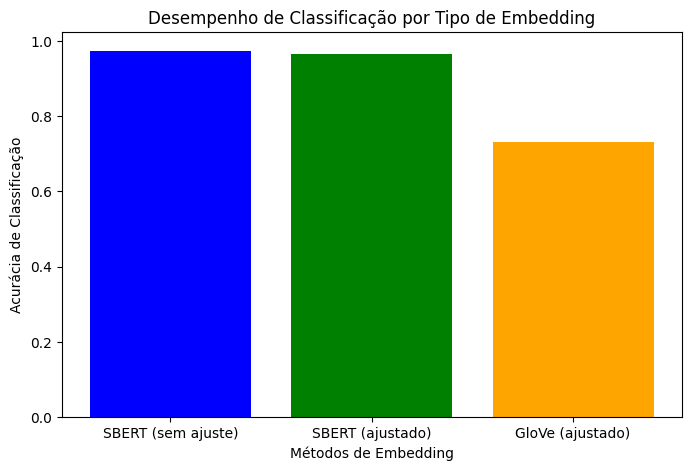

In [14]:
import matplotlib.pyplot as plt

# Avaliação das abordagens
from sklearn.cluster import KMeans

# Definir o número de clusters (n_classes) para os rótulos simulados
n_classes = 5  # Escolha o número de clusters desejado
kmeans = KMeans(n_clusters=n_classes, random_state=42)
generated_labels = kmeans.fit_predict(sbert_embeddings)

# Avaliar as três configurações de embeddings usando os rótulos gerados
accuracy_sbert = evaluate_embeddings_classification(sbert_embeddings, generated_labels)
accuracy_refined_sbert = evaluate_embeddings_classification(refined_embeddings, generated_labels)
accuracy_refined_glove = evaluate_embeddings_classification(glove_refined_embeddings, generated_labels)

# Resultados em dicionário para plotagem
results = {
    'SBERT (sem ajuste)': accuracy_sbert,
    'SBERT (ajustado)': accuracy_refined_sbert,
    'GloVe (ajustado)': accuracy_refined_glove
}

# Plotar o gráfico de barras comparando a acurácia de classificação
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'orange'])
plt.xlabel("Métodos de Embedding")
plt.ylabel("Acurácia de Classificação")
plt.title("Desempenho de Classificação por Tipo de Embedding")
plt.show()
